In [2]:
from helpers import *

def od_xml_to_df(file_path):

    tree = ET.parse(file_path)
    root = tree.getroot()
    gt_od_df =  xml2df_str(root, 'tazRelation')
    
    gt_od_vals = gt_od_df['count'].astype(float)
    print('total GT demand: ',gt_od_vals.sum())

    return gt_od_df

In [3]:
base_path = '/Users/rodrse/Downloads/ForSergio_nov26_2023_final'

In [4]:

taz2edge_xml = 'taz_new.xml'
net_xml = 'SFO.net.xml'
fixed_routes_xml = f'{base_path}/5hr_route_choice_set.csv'
od_duration_seconds = 5*60 

# duration of sample time for simulation output statistics
simulation_stat_freq_sec = od_duration_seconds
sim_end_time = od_duration_seconds
additional_xml = f'additional.add_statfreq{od_duration_seconds}.xml'

# suffix of simulation output edge file
EDGE_OUT_STR = 'edge_data_SFO.xml'
TRIPS2ODS_OUT_STR = 'trips.xml'
SUMO_PATH = '/usr/local/opt/sumo/share/sumo'

In [5]:
gt_version_str = 'v4'

# gt v4:
mean_od_val = 100
num_ods = 10

print('if you want to optimize them all (~86k) set num_ods as defined in commented line below')
#num_ods = routes_df.shape[0]

if you want to optimize them all (~86k) set num_ods as defined in commented line below


In [6]:
od_xml = f'gt_od_{gt_version_str}.xml'
file_gt = f'{base_path}/gt_od_{gt_version_str}.xml'
file_gt_edges = f'{base_path}/gt_edges_{gt_version_str}.csv'
prefix_output_gt = f'gt_{gt_version_str}'

In [7]:
# Get GT OD
print("Reading:",file_gt)
tree = ET.parse(file_gt)
root = tree.getroot()
gt_od_df =  xml2df_str(root, 'tazRelation')

gt_od_df.head()

Reading: /Users/rodrse/Downloads/ForSergio_nov26_2023_final/gt_od_v4.xml


,from,to,count,data
0,10100,10400,97.4,None
1,10100,10500,114.9,None
2,10100,105000,104.1,None
3,10100,108100,100.0,None
4,10100,108200,109.1,None


In [8]:
print("Reading:",fixed_routes_xml)
routes_df = pd.read_csv(fixed_routes_xml, index_col=0)

Reading: /Users/rodrse/Downloads/ForSergio_nov26_2023_final/5hr_route_choice_set.csv


In [9]:
gt_od_df = od_xml_to_df(file_gt)

total GT demand:  1044.3999999999999


In [10]:
gt_od_df.columns

Index(['from', 'to', 'count', 'data'], dtype='object')

## Trust Region BO

### Declare parameter space

In [13]:
import torch

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
dtype = torch.double

### Declare search space
# dimensionality of input space

dim_od = gt_od_df.shape[0]

bounds = torch.tensor([
    [ 0.0 for _ in range(dim_od)],
    [ 2000.0 for _ in range(dim_od)]
], device=device, dtype=dtype) 

bounds



tensor([[   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.]],
       dtype=torch.float64)

Read output of GT simulation

In [11]:

sim_edge_out_gt = f'{base_path}/{prefix_output_gt}_{EDGE_OUT_STR}'
df_edge_gt, _, _ = parse_loop_data_xml_to_pandas(base_path, sim_edge_out_gt, prefix_output_gt,SUMO_PATH)
# picking at edges as GT edges
num_gt_edges = df_edge_gt.shape[0]
print("Number of GT edges:",num_gt_edges)
gt_edge_data = df_edge_gt\
    .sort_values(by=['interval_nVehContrib'], ascending=False)\
    .iloc[:num_gt_edges]

#gt_edge_data.shape




Number of GT edges: 197


#### Bayesian optimization helpers

In [12]:
import os
import math
from dataclasses import dataclass

import torch
from botorch.acquisition import qExpectedImprovement
from botorch.fit import fit_gpytorch_mll
from botorch.generation import MaxPosteriorSampling
from botorch.models import SingleTaskGP
from botorch.optim import optimize_acqf
from botorch.utils.transforms import unnormalize
from botorch.utils.transforms import normalize
from torch.quasirandom import SobolEngine

import gpytorch
from gpytorch.constraints import Interval
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood

from botorch.models.transforms import Standardize


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double
SMOKE_TEST = os.environ.get("SMOKE_TEST")

In [13]:
@dataclass
class TurboState:
    dim: int
    batch_size: int
    length: float = 0.8
    length_min: float = 0.5**7
    length_max: float = 1.6
    failure_counter: int = 0
    failure_tolerance: int = float("nan")  # Note: Post-initialized
    success_counter: int = 0
    success_tolerance: int = 3  # Note: The original paper uses 3
    best_value: float = -float("inf")
    restart_triggered: bool = False

    def __post_init__(self):
        self.failure_tolerance = math.ceil(
            max([4.0 / self.batch_size, float(self.dim) / self.batch_size])
        )


def update_state(state, Y_next):
    if max(Y_next) > state.best_value + 1e-3 * math.fabs(state.best_value):
        state.success_counter += 1
        state.failure_counter = 0
    else:
        state.success_counter = 0
        state.failure_counter += 1

    if state.success_counter == state.success_tolerance:  # Expand trust region
        state.length = min(2.0 * state.length, state.length_max)
        state.success_counter = 0
    elif state.failure_counter == state.failure_tolerance:  # Shrink trust region
        state.length /= 2.0
        state.failure_counter = 0

    state.best_value = max(state.best_value, max(Y_next).item())
    if state.length < state.length_min:
        state.restart_triggered = True
    return state

In [14]:
def generate_batch(
    state,
    model,  # GP model
    X,  # Evaluated points on the domain [0, 1]^d
    Y,  # Function values
    batch_size,
    n_candidates=None,  # Number of candidates for Thompson sampling
    num_restarts=10,
    raw_samples=512,
    acqf="ts",  # "ei" or "ts"
):
    assert acqf in ("ts", "ei")
    assert X.min() >= 0.0 and X.max() <= 1.0 and torch.all(torch.isfinite(Y))
    if n_candidates is None:
        n_candidates = min(5000, max(2000, 200 * X.shape[-1]))

    # Scale the TR to be proportional to the lengthscales
    x_center = X[Y.argmax(), :].clone()
    weights = model.covar_module.base_kernel.lengthscale.squeeze().detach()
    weights = weights / weights.mean()
    weights = weights / torch.prod(weights.pow(1.0 / len(weights)))
    tr_lb = torch.clamp(x_center - weights * state.length / 2.0, 0.0, 1.0)
    tr_ub = torch.clamp(x_center + weights * state.length / 2.0, 0.0, 1.0)

    if acqf == "ts":
        dim = X.shape[-1]
        sobol = SobolEngine(dim, scramble=True)
        pert = sobol.draw(n_candidates).to(dtype=dtype, device=device)
        pert = tr_lb + (tr_ub - tr_lb) * pert

        # Create a perturbation mask
        prob_perturb = min(20.0 / dim, 1.0)
        mask = torch.rand(n_candidates, dim, dtype=dtype, device=device) <= prob_perturb
        ind = torch.where(mask.sum(dim=1) == 0)[0]
        mask[ind, torch.randint(0, dim - 1, size=(len(ind),), device=device)] = 1

        # Create candidate points from the perturbations and the mask
        X_cand = x_center.expand(n_candidates, dim).clone()
        X_cand[mask] = pert[mask]

        # Sample on the candidate points
        thompson_sampling = MaxPosteriorSampling(model=model, replacement=False)
        with torch.no_grad():  # We don't need gradients when using TS
            X_next = thompson_sampling(X_cand, num_samples=batch_size)

    elif acqf == "ei":
        ei = qExpectedImprovement(model, Y.max(), maximize=True)
        X_next, acq_value = optimize_acqf(
            ei,
            bounds=torch.stack([tr_lb, tr_ub]),
            q=batch_size,
            num_restarts=num_restarts,
            raw_samples=raw_samples,
        )

    return X_next

In [15]:
#n0=25
df_0 = pd.read_csv(base_path + f"/initial_search/data_set_ods_0_2000.csv")

In [15]:
#/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/vanilla_bo
### Run loop
NITER = 250
BATCH_SIZE = 1
dim=dim_od
state = TurboState(dim, BATCH_SIZE)

SMOKE_TEST  = False
NUM_RESTARTS = 10 if not SMOKE_TEST else 2
RAW_SAMPLES = 512 if not SMOKE_TEST else 4
N_CANDIDATES = min(5000, max(2000, 200 * dim)) if not SMOKE_TEST else 4
max_cholesky_size = float("inf")  # Always use Cholesky
torch.manual_seed(0)


best_value = []

# Data frame of current training data
df_training = df_0
df_training["bo_iteration"] = 0


NameError: name 'TurboState' is not defined

In [17]:

#num_epsilon_iter = 2
bayes_opt_method = "bayesian_optimization/trust_region_experiment_2"
ods_epsilon = []
loss_all = []
batch_data_i = []


In [19]:

# Base OD which we will update their count entries
base_od = gt_od_df.copy()
gt_od_vals = gt_od_df['count'].astype(float).to_numpy()

for i in range(NITER):
#for i in range(225,500):

    file_od_epsilon_xml = f'{bayes_opt_method}/gt_od_{gt_version_str}_{i}.xml'
    prefix_output = f'{bayes_opt_method}/bayesOpt_{i}'


    ########
    # Start BO step
    ########

    print(f"########### BO iteration={i+1} ###########")

    # Obtain sampling locations x
    train_X = torch.from_numpy(
        df_training[[col for col in df_training.columns if "x" in col]].values
    )    

    #n_samples = train_X.shape[]
    #print("Using ")
    # Normalize
    train_X_norm = normalize(train_X,bounds)

    # Obtain reponse data
    train_Y = -torch.from_numpy(df_training[["loss"]].values) # Take negative

    ###
    #Obtain next sampling location given current training data
    ###

    # best value so far
    best_y = train_Y.max()
    best_value.append(best_y)
    print(f"##### best_value={best_y} #####")


    # Update state
    state = update_state(state=state, Y_next=train_Y)

    # Fit model
    print("Fitting GP model...")

    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
    # Use the same lengthscale prior as in the TuRBO paper
    covar_module = ScaleKernel(  
        MaternKernel(
            nu=2.5, ard_num_dims=dim, lengthscale_constraint=Interval(0.005, 4.0)
        )
    )
    model = SingleTaskGP(
        train_X_norm, train_Y, 
        covar_module=covar_module, likelihood=likelihood, 
        outcome_transform=Standardize(m=1)
    )
    mll = ExactMarginalLogLikelihood(model.likelihood, model)

    # Do the fitting and acquisition function optimization inside the Cholesky context
    with gpytorch.settings.max_cholesky_size(max_cholesky_size):
        # Fit the model
        fit_gpytorch_mll(mll)

        # Create a batch
        print("Optimizing acquisition function...")
        new_x_turbo = generate_batch(
            state=state,
            model=model,
            X=train_X_norm,
            Y=train_Y,
            batch_size=BATCH_SIZE,
            n_candidates=N_CANDIDATES,
            num_restarts=NUM_RESTARTS,
            raw_samples=RAW_SAMPLES,
            acqf="ts", # "ts"
        )

    x_i = unnormalize(new_x_turbo,bounds)
    x_i = x_i.cpu().detach().numpy()

    ########
    # End BO step
    ########    


    # Sample simulator (inner loop across all sampling locations within a batch)
    # TODO: Parallelize
    batch_data_i = []
    for j in range(BATCH_SIZE):
        loss_all = []
        print(f"########### Sampling location={j+1} ###########")

        # Generate OD
        #curr_od = gt_od_vals.copy()
        curr_od = x_i[j]

        print(f'total expected GT demand: {np.sum(curr_od)}')

        base_od['count'] = curr_od
        # round to 1 decimal point
        base_od['count'] = [round(elem, 1) for elem in base_od['count']]     
        base_od = base_od.rename(columns={'fromTaz':'from', 'toTaz':'to'})        
        create_taz_xml(file_od_epsilon_xml, base_od, od_duration_seconds, base_path)

        # simulate gt od
        simulate_od(file_od_epsilon_xml, 
                    prefix_output, 
                    base_path, 
                    net_xml, 
                    taz2edge_xml, 
                    additional_xml, 
                    routes_df,
                    sim_end_time,
                    TRIPS2ODS_OUT_STR)

        ## Compute loss
        sim_edge_out = f'{base_path}/{prefix_output}_{EDGE_OUT_STR}'
        print(sim_edge_out)
        curr_loop_stats, _, _ = parse_loop_data_xml_to_pandas(base_path, sim_edge_out,prefix_output,SUMO_PATH)
        curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, curr_loop_stats)

        loss_all.append(curr_loss)
        print(f"############## loss: {curr_loss} ##############")

        # Parse training data
        df_j = pd.DataFrame(x_i[j].reshape(1,dim_od),
                            columns = [f"x_{i+1}" for i in range(dim_od)])
        df_j['loss'] = curr_loss
        batch_data_i.append(df_j)

    df_i = pd.concat(batch_data_i)
    df_i["bo_iteration"] = i+1

    df_training = pd.concat([df_training,df_i])


########### BO iteration=1 ###########
##### best_value=-0.2430874984699992 #####
Fitting GP model...
Optimizing acquisition function...
########### Sampling location=1 ###########
total expected GT demand: 10379.73056233735
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_0.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_0.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_0_trips_beforeRteUpdates.xml
Success.time 299.92
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_0_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSer

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9950.532307252188
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_115.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_115.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_115_trips_beforeRteUpdates.xml
Success.time 299.12
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_115_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_115_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9940.11835825491
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_116.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_116.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_116_trips_beforeRteUpdates.xml
Success.time 299.37
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_116_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_116_trips.xml -b 0 -e 300 --additional-files /Users/

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9958.17604370083
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_117.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_117.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_117_trips_beforeRteUpdates.xml
Success.time 299.49
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_117_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_117_trips.xml -b 0 -e 300 --additional-files /Users/

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9976.133687850077
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_118.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_118.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_118_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_118_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_118_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9979.026672714515
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_119.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_119.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_119_trips_beforeRteUpdates.xml
Success.time 299.07
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_119_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_119_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9943.866496268638
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_120.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_120.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_120_trips_beforeRteUpdates.xml
Success.time 298.99
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_120_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_120_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9980.90439646481
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_121.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_121.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_121_trips_beforeRteUpdates.xml
Success.time 299.77
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_121_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_121_trips.xml -b 0 -e 300 --additional-files /Users/

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9969.021283888422
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_122.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_122.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_122_trips_beforeRteUpdates.xml
Success.time 299.08
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_122_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_122_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9977.214987823629
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_123.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_123.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_123_trips_beforeRteUpdates.xml
Success.time 299.49
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_123_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_123_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9992.122106465224
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_124.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_124.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_124_trips_beforeRteUpdates.xml
Success.time 299.49
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_124_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_124_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9974.719726684874
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_125.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_125.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_125_trips_beforeRteUpdates.xml
Success.time 299.12
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_125_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_125_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9966.177882165766
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_126.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_126.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_126_trips_beforeRteUpdates.xml
Success.time 299.49
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_126_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_126_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9971.316654522108
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_127.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_127.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_127_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_127_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_127_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9973.971431914633
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_128.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_128.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_128_trips_beforeRteUpdates.xml
Success.time 299.49
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_128_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_128_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9972.069566259528
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_129.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_129.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_129_trips_beforeRteUpdates.xml
Success.time 299.49
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_129_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_129_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9967.874561679555
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_130.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_130.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_130_trips_beforeRteUpdates.xml
Success.time 299.49
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_130_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_130_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9971.10811808052
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_131.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_131.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_131_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_131_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_131_trips.xml -b 0 -e 300 --additional-files /Users/

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9962.305770619943
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_132.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_132.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_132_trips_beforeRteUpdates.xml
Success.time 299.12
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_132_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_132_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9965.137410173813
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_133.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_133.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_133_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_133_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_133_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9959.82753767714
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_134.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_134.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_134_trips_beforeRteUpdates.xml
Success.time 299.49
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_134_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_134_trips.xml -b 0 -e 300 --additional-files /Users/

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9967.572146757842
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_135.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_135.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_135_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_135_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_135_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9965.433802247044
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_136.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_136.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_136_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_136_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_136_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9965.608134895972
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_137.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_137.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_137_trips_beforeRteUpdates.xml
Success.time 299.49
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_137_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_137_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9965.124002203196
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_138.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_138.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_138_trips_beforeRteUpdates.xml
Success.time 299.12
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_138_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_138_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9969.525726455639
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_139.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_139.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_139_trips_beforeRteUpdates.xml
Success.time 299.49
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_139_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_139_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9973.610701487016
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_140.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_140.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_140_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_140_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_140_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9974.165424527046
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_141.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_141.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_141_trips_beforeRteUpdates.xml
Success.time 299.12
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_141_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_141_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9962.360502392894
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_142.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_142.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_142_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_142_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_142_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9975.507377138614
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_143.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_143.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_143_trips_beforeRteUpdates.xml
Success.time 299.49
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_143_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_143_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9969.473056169896
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_144.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_144.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_144_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_144_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_144_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9964.383340551714
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_145.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_145.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_145_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_145_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_145_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9969.028607607492
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_146.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_146.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_146_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_146_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_146_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9962.181330162171
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_147.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_147.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_147_trips_beforeRteUpdates.xml
Success.time 299.49
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_147_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_147_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9967.269771442541
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_148.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_148.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_148_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_148_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_148_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9964.195768794021
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_149.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_149.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_149_trips_beforeRteUpdates.xml
Success.time 299.49
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_149_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_149_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9964.701689545902
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_150.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_150.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_150_trips_beforeRteUpdates.xml
Success.time 299.49
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_150_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_150_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9966.949494162736
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_151.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_151.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_151_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_151_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_151_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9964.340048596629
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_152.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_152.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_152_trips_beforeRteUpdates.xml
Success.time 299.49
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_152_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_152_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9963.432079370163
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_153.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_153.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_153_trips_beforeRteUpdates.xml
Success.time 299.49
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_153_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_153_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9967.68266354079
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_154.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_154.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_154_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_154_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_154_trips.xml -b 0 -e 300 --additional-files /Users/

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9963.670027770866
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_155.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_155.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_155_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_155_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_155_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9966.50348613614
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_156.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_156.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_156_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_156_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_156_trips.xml -b 0 -e 300 --additional-files /Users/

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9965.80054539077
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_157.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_157.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_157_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_157_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_157_trips.xml -b 0 -e 300 --additional-files /Users/

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9966.16788796754
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_158.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_158.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_158_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_158_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_158_trips.xml -b 0 -e 300 --additional-files /Users/

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9965.58933311794
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_159.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_159.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_159_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_159_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_159_trips.xml -b 0 -e 300 --additional-files /Users/

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9964.613148815171
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_160.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_160.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_160_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_160_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_160_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9966.3601813425
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_161.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_161.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_161_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_161_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_161_trips.xml -b 0 -e 300 --additional-files /Users/r

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9965.11641299834
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_162.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_162.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_162_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_162_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_162_trips.xml -b 0 -e 300 --additional-files /Users/

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9966.89576183096
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_163.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_163.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_163_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_163_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_163_trips.xml -b 0 -e 300 --additional-files /Users/

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9965.929730672282
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_164.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_164.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_164_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_164_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_164_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9964.132219843243
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_165.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_165.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_165_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_165_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_165_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9966.038910912628
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_166.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_166.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_166_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_166_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_166_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9964.816118007118
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_167.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_167.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_167_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_167_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_167_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9966.177590378093
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_168.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_168.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_168_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_168_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_168_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9965.489522678057
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_169.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_169.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_169_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_169_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_169_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9965.286405882845
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_170.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_170.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_170_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_170_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_170_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9965.321218463374
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_171.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_171.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_171_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_171_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_171_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9964.72305138563
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_172.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_172.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_172_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_172_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_172_trips.xml -b 0 -e 300 --additional-files /Users/

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9965.357442748416
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_173.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_173.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_173_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_173_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_173_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9965.377731277073
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_174.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_174.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_174_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_174_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_174_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9965.510976655596
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_175.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_175.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_175_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_175_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_175_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9965.547825524618
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_176.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_176.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_176_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_176_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_176_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9965.48125715712
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_177.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_177.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_177_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_177_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_177_trips.xml -b 0 -e 300 --additional-files /Users/

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9965.162863190835
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_178.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_178.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_178_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_178_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_178_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9965.390627549064
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_179.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_179.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_179_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_179_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_179_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9964.767044298864
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_180.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_180.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_180_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_180_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_180_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9965.292285712305
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_181.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_181.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_181_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_181_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_181_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9964.529567714166
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_182.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_182.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_182_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_182_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_182_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9965.109086146089
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_183.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_183.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_183_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_183_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_183_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9964.989304694067
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_184.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_184.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_184_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_184_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_184_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9964.981216881519
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_185.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_185.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_185_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_185_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_185_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9964.888392790812
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_186.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_186.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_186_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_186_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_186_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9965.43242779183
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_187.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_187.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_187_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_187_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_187_trips.xml -b 0 -e 300 --additional-files /Users/

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9965.113842716091
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_188.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_188.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_188_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_188_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_188_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9965.224053107726
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_189.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_189.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_189_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_189_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_189_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9965.182391398346
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_190.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_190.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_190_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_190_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_190_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9964.919244263308
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_191.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_191.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_191_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_191_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_191_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9965.016918781164
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_192.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_192.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_192_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_192_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_192_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9965.29731383937
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_193.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_193.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_193_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_193_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_193_trips.xml -b 0 -e 300 --additional-files /Users/

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9965.21704865659
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_194.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_194.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_194_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_194_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_194_trips.xml -b 0 -e 300 --additional-files /Users/

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9965.18689803401
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_195.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_195.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_195_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_195_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_195_trips.xml -b 0 -e 300 --additional-files /Users/

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9965.079318907648
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_196.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_196.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_196_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_196_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_196_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9965.112811573894
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_197.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_197.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_197_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_197_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_197_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9965.195680569996
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_198.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_198.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_198_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_198_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_198_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9965.19535293654
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_199.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_199.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_199_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_199_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_199_trips.xml -b 0 -e 300 --additional-files /Users/

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9965.144907521058
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_200.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_200.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_200_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_200_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_200_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9965.122540252121
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_201.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_201.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_201_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_201_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_201_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9965.118790954242
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_202.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_202.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_202_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_202_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_202_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9965.119398971021
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_203.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_203.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_203_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_203_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_203_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9965.154307621027
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_204.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_204.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_204_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_204_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_204_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9965.138272836859
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_205.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_205.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_205_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_205_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_205_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9965.134368438798
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_206.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_206.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_206_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_206_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_206_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9965.18944746353
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_207.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_207.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_207_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_207_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_207_trips.xml -b 0 -e 300 --additional-files /Users/

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9965.113644647528
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_208.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_208.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_208_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_208_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_208_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9965.185726253841
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_209.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_209.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_209_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_209_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_209_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9965.148303789796
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_210.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_210.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_210_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_210_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_210_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9965.202456314533
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_211.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_211.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_211_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_211_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_211_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9965.051626721235
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_212.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_212.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_212_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_212_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_212_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9965.155780133646
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_213.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_213.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_213_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_213_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_213_trips.xml -b 0 -e 300 --additional-files /Users

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


########### Sampling location=1 ###########
total expected GT demand: 9965.21948313151
Created  /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_214.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/taz_new.xml --tazrelation-files /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/gt_od_v4_214.xml -o /Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_214_trips_beforeRteUpdates.xml
Success.time 299.83
###### Running SUMO #######
Seed 0
sumo --output-prefix bayesian_optimization/trust_region_experiment_2/bayesOpt_214_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/SFO.net.xml --routes=/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/bayesOpt_214_trips.xml -b 0 -e 300 --additional-files /Users/

ModelFittingError: All attempts to fit the model have failed. For more information, try enabling botorch.settings.debug mode.

In [20]:
df_training.shape

(265, 12)

In [28]:
print(base_path + f"/{bayes_opt_method}/data_set_bayes_opt.csv")
df_training.to_csv(base_path + f"/{bayes_opt_method}/data_set_bayes_opt.csv",index=None)

/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_bo/data_set_bayes_opt.csv


In [18]:
df_training = pd.read_csv(base_path + f"/{bayes_opt_method}/data_set_bayes_opt.csv")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/rodrse/Downloads/ForSergio_nov26_2023_final/bayesian_optimization/trust_region_experiment_2/data_set_bayes_opt.csv'

In [35]:
df_training.shape

(225, 12)

In [33]:
#file_od_epsilon_xml = f'{bayes_opt_method}/gt_od_{gt_version_str}_{i}.xml'
#prefix_output = f'{bayes_opt_method}/bayesOpt_{i}'

bayes_opt_method = "bayesian_optimization/trust_region_bo"


edge_epsilon_all = []
for o1 in range(200):
    curr_prefix = f'{bayes_opt_method}/bayesOpt_{o1}'
    sim_edge_out = f'{base_path}/{curr_prefix}_{EDGE_OUT_STR}'
    curr_loop_stats, _, _ = parse_loop_data_xml_to_pandas(base_path, sim_edge_out, curr_prefix,SUMO_PATH)
    edge_epsilon_all.append(curr_loop_stats)

In [34]:
loss_all = []
for o1 in range(200):
    curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, edge_epsilon_all[o1])
    print(curr_loss)
    loss_all.append(curr_loss)

number of GT edges: 197
0.0701859227016522
number of GT edges: 197
0.05349524329513749
number of GT edges: 197
0.08346025738922286
number of GT edges: 197
0.08240055965562595
number of GT edges: 197
0.08562297929233549
number of GT edges: 197
0.06868240131593333
number of GT edges: 197
0.055899863565088005
number of GT edges: 197
0.06665149982914637
number of GT edges: 197
0.07244375808284251
number of GT edges: 197
0.09072672856361678
number of GT edges: 197
0.0543267120357218
number of GT edges: 197
0.04470195033986217
number of GT edges: 197
0.6291115823790786
number of GT edges: 197
0.05051240288465363
number of GT edges: 197
0.05146096684267684
number of GT edges: 197
0.048777857191191
number of GT edges: 197
0.041300367415450415
number of GT edges: 197
0.046117699177946565
number of GT edges: 197
0.046270914547456694
number of GT edges: 197
0.048206198177913086
number of GT edges: 197
0.048693141831300205
number of GT edges: 197
0.0670485272988076
number of GT edges: 197
0.053329

## plot trajectories

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [45]:
df_plot = pd.DataFrame(data = {
    "bo_iteration": np.arange(len(loss_all)),
    "loss" : np.array(loss_all)    
})

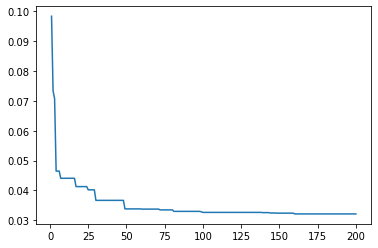

In [47]:
df_plot = df_training.query('bo_iteration>0')
import numpy as np
import matplotlib.pyplot as plt

x = df_plot['bo_iteration']
y = df_plot['loss'].cummin()

plt.plot(x,y)
#plt.legend(title='Parameter where:')
plt.show()

number of GT edges: 196
number of GT edges: 196
number of GT edges: 196
number of GT edges: 196
number of GT edges: 196
number of GT edges: 196
number of GT edges: 196
number of GT edges: 196
number of GT edges: 196
number of GT edges: 196


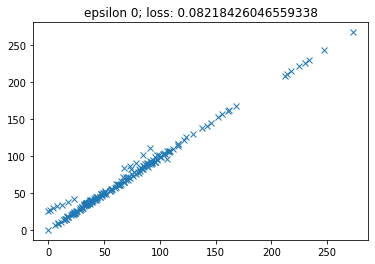

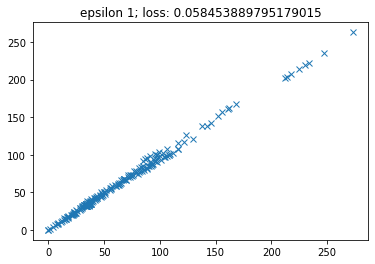

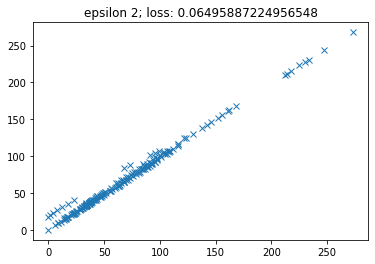

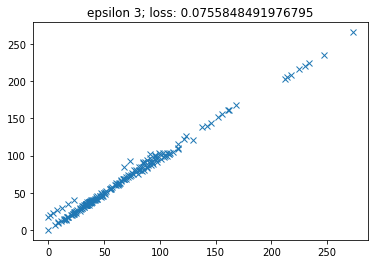

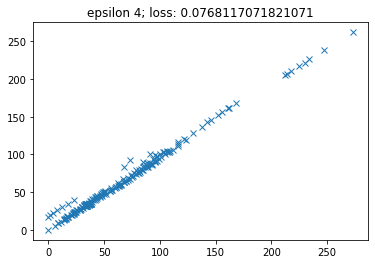

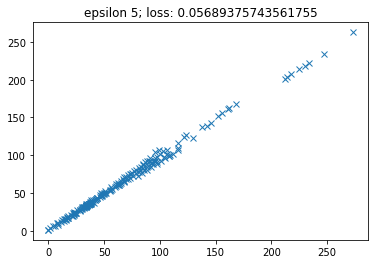

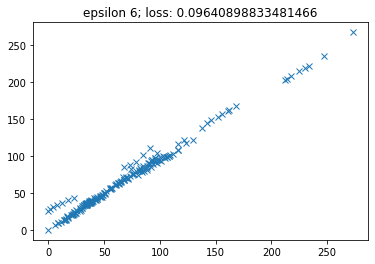

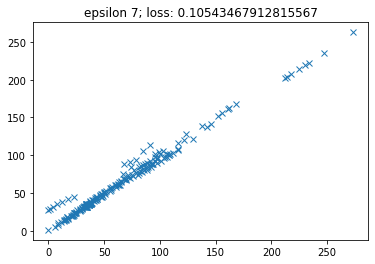

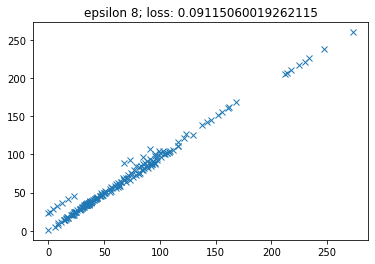

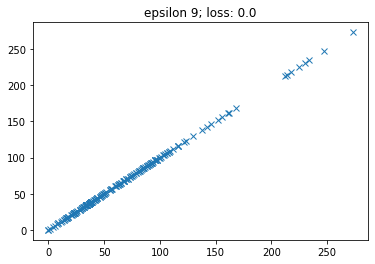

In [39]:
import matplotlib.pyplot as plt

for o1 in range(num_epsilon_iter):
    df1b = gt_edge_data.merge(edge_epsilon_all[o1], on=['edge_id'], how='left')
    curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, edge_epsilon_all[o1])

    plt.figure()
    plt.plot(df1b.interval_nVehContrib_x, df1b.interval_nVehContrib_y, 'x') 
    plt.title(f'epsilon {o1}; loss: {curr_loss}')
